# Autoestudo Ponderado: Detecção de Fraudes no IEEE-CIS Fraud Detection com LSTM no PyTorch

# Alunos:
- Henrique Cox
- Nicollas Isaac

# Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

2025-09-19 05:17:52.680216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 05:17:52.718808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 05:17:53.927683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Importando o Database

In [ ]:
# === Loader robusto para CSV do Google Drive ===
import re, io, sys, subprocess, os
import pandas as pd

def _ensure_gdown():
    try:
        import gdown  # noqa
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])

def _extract_file_id(link_or_id: str) -> str:
    # Aceita: ID puro OU qualquer URL do Drive
    m = re.search(r'/d/([A-Za-z0-9_-]{10,})/', link_or_id)
    if m:
        return m.group(1)
    m = re.search(r'id=([A-Za-z0-9_-]{10,})', link_or_id)
    if m:
        return m.group(1)
    # se já for um id
    if re.fullmatch(r'[A-Za-z0-9_-]{10,}', link_or_id):
        return link_or_id
    raise ValueError("Não consegui extrair o file_id do link. Passe um link do Drive válido ou o ID.")

def read_gdrive_csv(link_or_id: str, filename: str, **read_csv_kwargs) -> pd.DataFrame:
    """
    Baixa via gdown e lê com pandas.
    - link_or_id: link completo (view?usp=sharing) ou só o ID
    - filename: nome local (ex.: 'train_identity.csv' – extensão pode ser .csv, .csv.gz, etc.)
    """
    file_id = _extract_file_id(link_or_id)
    _ensure_gdown()
    import gdown

    # Se já existe em disco, não baixa de novo (útil pra reexecutar célula)
    if not os.path.exists(filename):
        # 'fuzzy=True' permite passar link completo também
        try:
            # Tenta baixar pelo ID primeiro
            gdown.download(id=file_id, output=filename, quiet=False)
            if not os.path.exists(filename) or os.path.getsize(filename) == 0:
                # fallback: tenta pelo link de download direto
                url = f"https://drive.google.com/uc?export=download&id={file_id}"
                gdown.download(url, output=filename, quiet=False, fuzzy=True)
        except Exception as e:
            raise RuntimeError(f"Falha no download via gdown: {e}")

    # Leitura com pandas (compression='infer' cobre .gz/.zip)
    read_args = dict(low_memory=False, compression='infer')
    read_args.update(read_csv_kwargs)

    try:
        df = pd.read_csv(filename, **read_args)
        return df
    except pd.errors.ParserError as e:
        # Diagnóstico: se por acaso baixou HTML em vez de CSV
        with open(filename, 'rb') as fh:
            head = fh.read(400).decode('utf-8', errors='ignore')
        if '<html' in head.lower():
            raise RuntimeError(
                "O Drive entregou HTML (provável tela de permissão/antivírus). "
                "Verifique se o arquivo está com compartilhamento 'Qualquer pessoa com o link – Leitor'."
            ) from e
        # Outra causa comum: tipos mistos -> força tudo como texto
        try:
            df = pd.read_csv(filename, dtype=str, **{k:v for k,v in read_args.items() if k!='low_memory'})
            return df
        except Exception:
            raise

# === Use com seus links (podem ser os mesmos que você mandou) ===
id_link_identity = "https://drive.google.com/file/d/1TYGxSpIjquPm4w3pdSqIB6Q7lzHWiMT1/view?usp=sharing"
id_link_transaction = "https://drive.google.com/file/d/1mTySP5q2NgKd8oS4RnmRBGzRNVIpaFtG/view?usp=sharing"

train_identity = read_gdrive_csv(id_link_identity, "train_identity.csv")
train_transaction = read_gdrive_csv(id_link_transaction, "train_transaction.csv")

print("Train Identity:")
print(train_identity.head())

print("\nTrain Transaction:")
print(train_transaction.head())


Train Identity:
   TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType  

# Pré-Processamento

In [ ]:
print("Estatísticas Descritivas (Train Identity):")
print(train_identity.describe())

print("\nEstatísticas Descritivas (Train Transaction):")
print(train_transaction.describe())


Estatísticas Descritivas (Train Identity):
       TransactionID          id_01          id_02         id_03  \
count   1.442330e+05  144233.000000  140872.000000  66324.000000   
mean    3.236329e+06     -10.170502  174716.584708      0.060189   
std     1.788496e+05      14.347949  159651.816856      0.598231   
min     2.987004e+06    -100.000000       1.000000    -13.000000   
25%     3.077142e+06     -10.000000   67992.000000      0.000000   
50%     3.198818e+06      -5.000000  125800.500000      0.000000   
75%     3.392923e+06      -5.000000  228749.000000      0.000000   
max     3.577534e+06       0.000000  999595.000000     10.000000   

              id_04          id_05          id_06        id_07        id_08  \
count  66324.000000  136865.000000  136865.000000  5155.000000  5155.000000   
mean      -0.058938       1.615585      -6.698710    13.285354   -38.600388   
std        0.701015       5.249856      16.491104    11.384207    26.084899   
min      -28.000000     -72.

## Insights Iniciais

### Train Identity:
  - id_01, id_02, etc.:

    A maioria das colunas apresenta dados numéricos, com algumas delas contendo valores nulos ou negativos. Algumas colunas, como id_03 e id_04, possuem muitos valores ausentes, o que exige um pré-processamento para lidar com isso.

    Algumas colunas têm uma grande dispersão (ex: id_02 com valores entre 1 e 999595), o que sugere que as variáveis podem ter diferentes escalas.

  - id_36, id_37, id_38:

    Essas colunas parecem ser variáveis categóricas com valores como T e F (provavelmente True e False).

    Muitos valores ausentes: As colunas id_07, id_08, e outras têm muitos valores ausentes, o que pode ser um problema na hora da modelagem.

### Train Transaction

- TransactionAmt:

    A variável TransactionAmt (valor da transação) tem uma média de cerca de 135, com um desvio padrão de 239. O que indica que a maioria das transações são de valores mais baixos, mas há algumas transações muito altas (máximo de 31937). A presença desses valores mais altos faz com que seja necessário identificar os outliers.

- isFraud:

    A distribuição da variável isFraud mostra que temos um dataset bem desbalanceado, com muito mais transações não fraudulentas (0) do que fraudulentas (1).

- Outliers em TransactionAmt e variáveis V*:

    A coluna TransactionAmt apresenta valores muito elevados (máximo de 31937), o que pode ser um possível outlier.

    As variáveis V* (como V330, V331, etc.) também apresentam valores muito altos (ex: máximo de 160000).

## Outliers

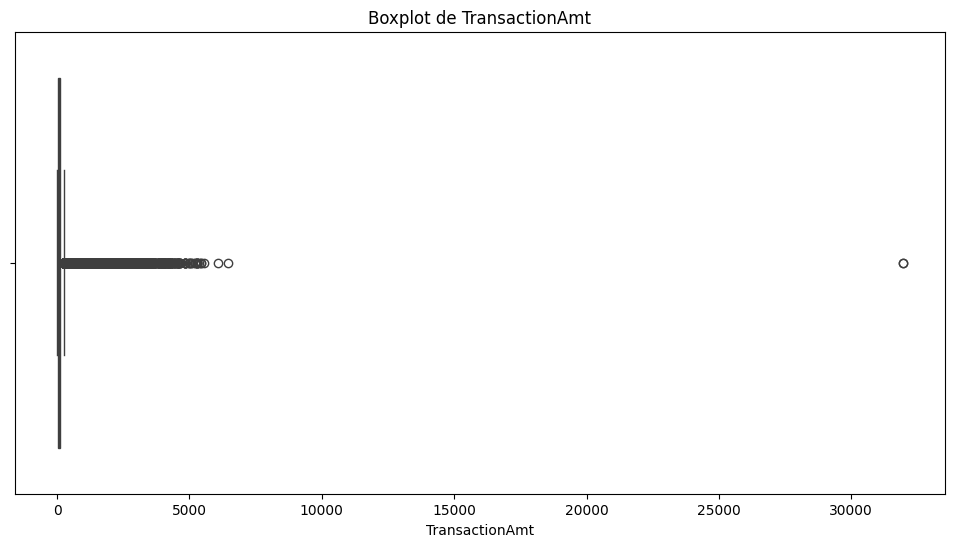

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_transaction['TransactionAmt'])
plt.title('Boxplot de TransactionAmt')
plt.show()

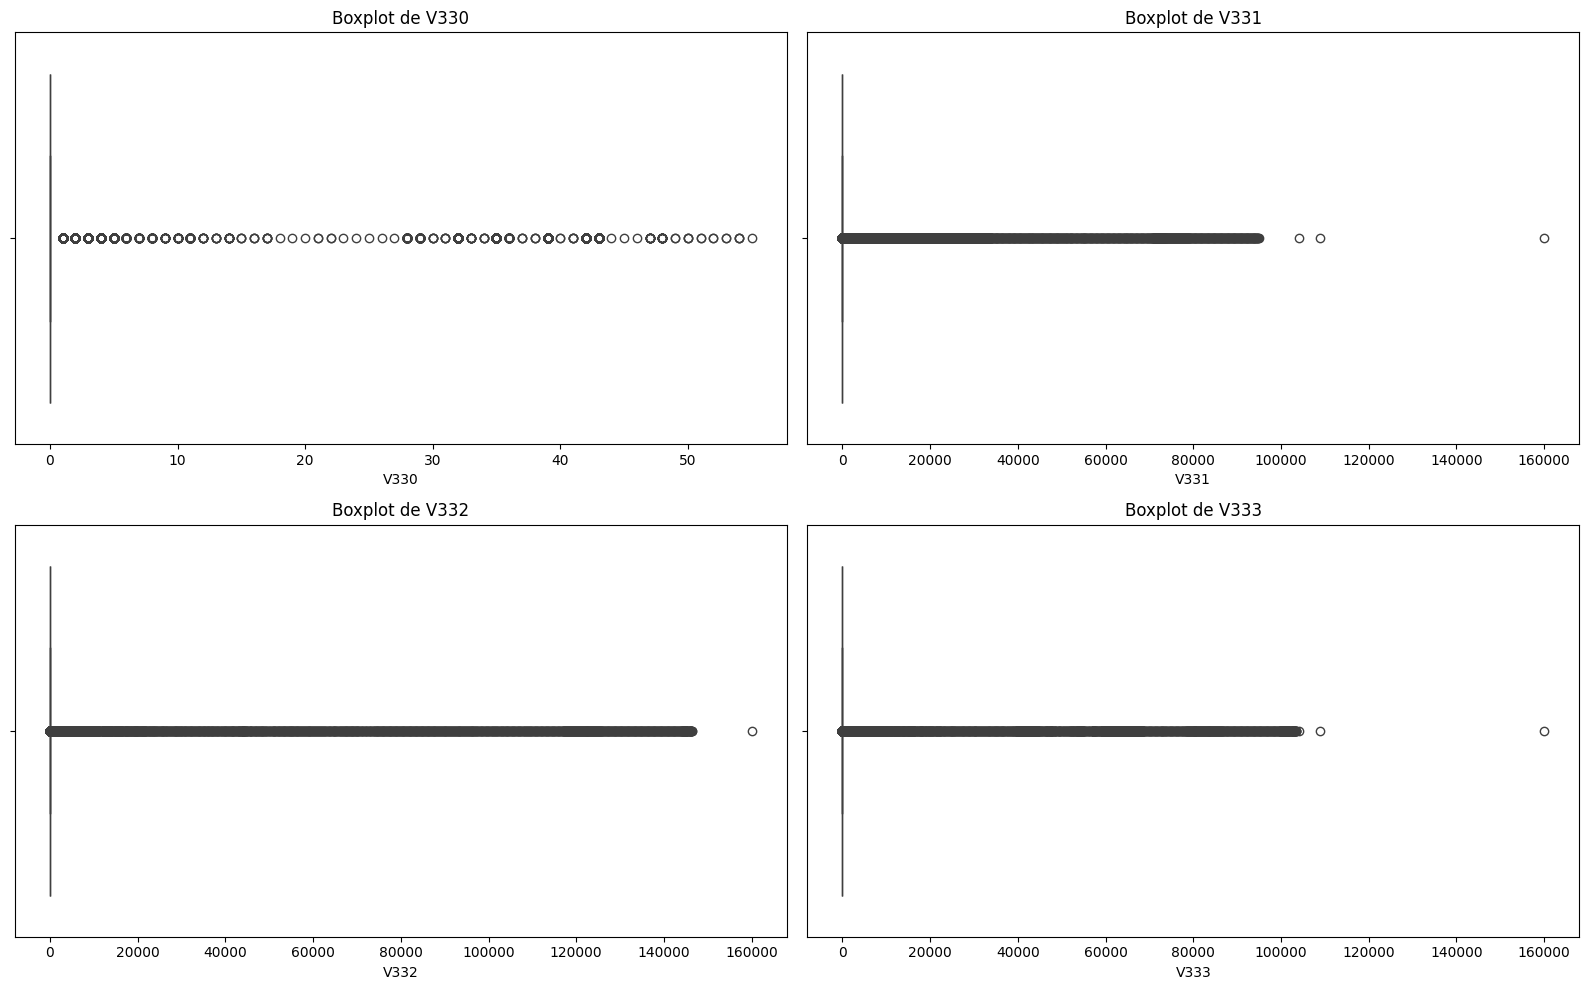

In [ ]:
variables_v = ['V330', 'V331', 'V332', 'V333']

plt.figure(figsize=(16, 10))
for i, var in enumerate(variables_v):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=train_transaction[var])
    plt.title(f'Boxplot de {var}')
plt.tight_layout()
plt.show()


In [ ]:
z_scores_transaction_amt = stats.zscore(train_transaction['TransactionAmt'])

outliers_transaction_amt = train_transaction['TransactionAmt'][abs(z_scores_transaction_amt) > 3]
print(f"Outliers em TransactionAmt (com Z-score > 3):\n{outliers_transaction_amt}")

variables_v_z = ['V330', 'V331', 'V332', 'V333']
for var in variables_v_z:
    z_scores_v = stats.zscore(train_transaction[var].dropna())
    outliers_v = train_transaction[var].dropna()[abs(z_scores_v) > 3]
    print(f"\nOutliers em {var} (com Z-score > 3):")
    print(outliers_v)

Outliers em TransactionAmt (com Z-score > 3):
60        2454.00
110       1153.95
133       2594.95
135       3000.00
163        973.95
           ...   
590402    1331.00
590405    2286.27
590408    1615.74
590464    1731.30
590519    1659.95
Name: TransactionAmt, Length: 10093, dtype: float64

Outliers em V330 (com Z-score > 3):
100920    15.0
534825    15.0
534826    16.0
534831    17.0
534841    17.0
          ... 
578768    15.0
579667    22.0
580170    16.0
580823    16.0
580827    17.0
Name: V330, Length: 1360, dtype: float64

Outliers em V331 (com Z-score > 3):
81959      19750.0
81961      20250.0
82045      20750.0
211103     55125.0
214364     30250.0
            ...   
564463     22270.0
564464     22075.0
583406     52030.0
583412    104060.0
589703     21600.0
Name: V331, Length: 941, dtype: float64

Outliers em V332 (com Z-score > 3):
211103     55125.0
214364     41690.0
391494     35176.5
424805     51200.0
424838    108800.0
            ...   
579667    146203.0
58143

### 1. Tratamento de Outliers na Variável TransactionAmt
#### Substituir Outliers por Percentil 95 e 5


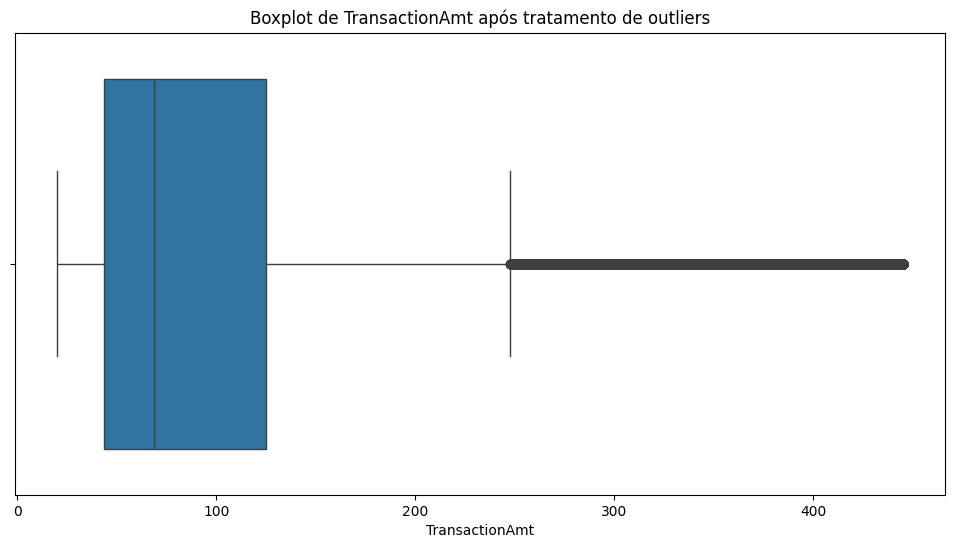

In [ ]:
lower_percentile = train_transaction['TransactionAmt'].quantile(0.05)
upper_percentile = train_transaction['TransactionAmt'].quantile(0.95)

train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].apply(
    lambda x: upper_percentile if x > upper_percentile else (lower_percentile if x < lower_percentile else x)
)

plt.figure(figsize=(12, 6))
sns.boxplot(x=train_transaction['TransactionAmt'])
plt.title('Boxplot de TransactionAmt após tratamento de outliers')
plt.show()

### Tratamento de Outliers nas Variáveis V330, V331, V332, V333
#### Substituir Outliers por Percentis

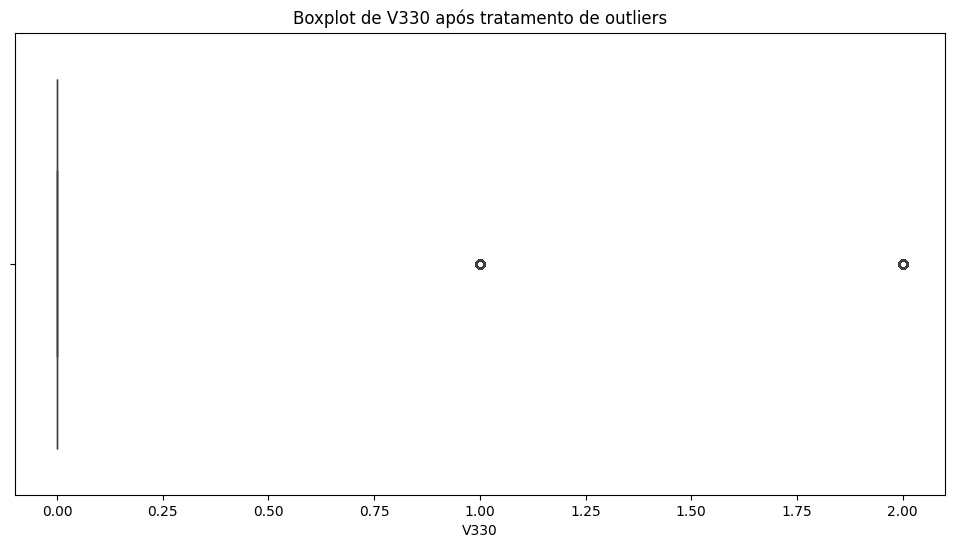

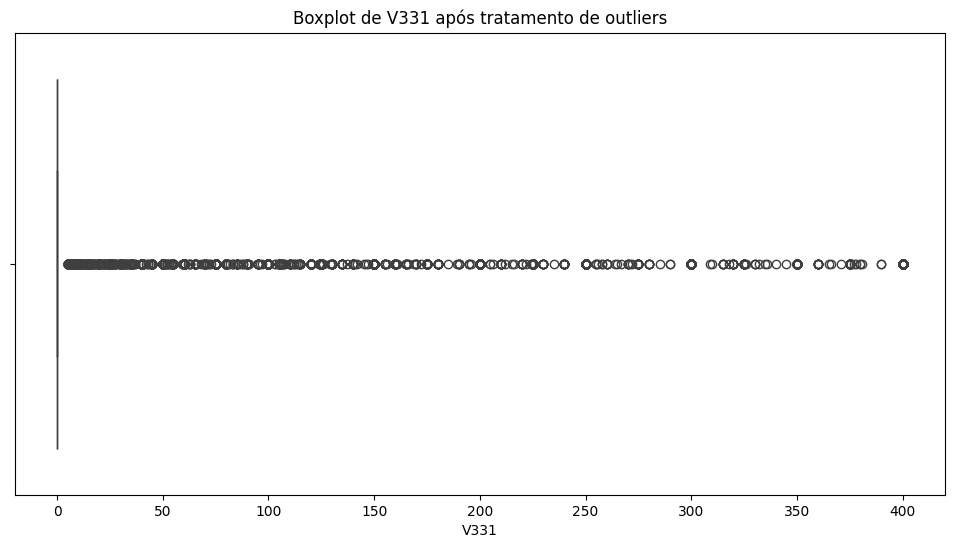

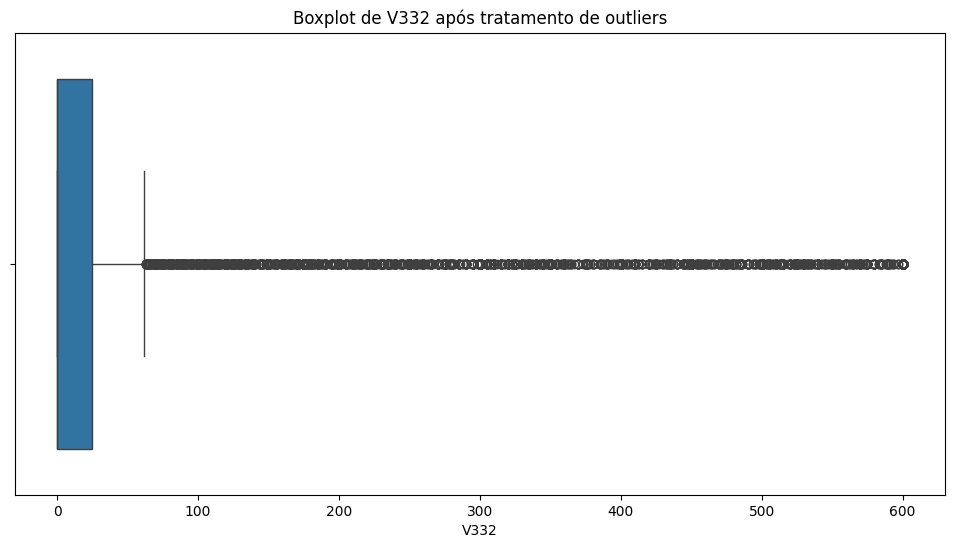

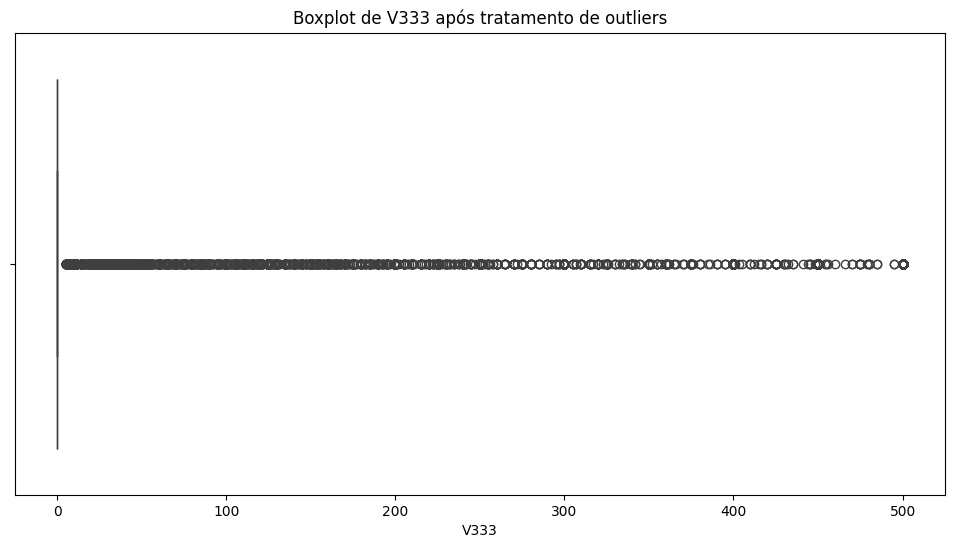

In [ ]:
variables_v = ['V330', 'V331', 'V332', 'V333']

for var in variables_v:
    lower_percentile = train_transaction[var].quantile(0.05)
    upper_percentile = train_transaction[var].quantile(0.95)

    train_transaction[var] = train_transaction[var].apply(
        lambda x: upper_percentile if x > upper_percentile else (lower_percentile if x < lower_percentile else x)
    )

for var in variables_v:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=train_transaction[var])
    plt.title(f'Boxplot de {var} após tratamento de outliers')
    plt.show()


## Conclusão

Decidimos seguir com a substituição dos outliers em vez de sua remoção por algumas razões importantes, que podem ser observadas nos gráficos gerados.

- Justificativa para Substituição em vez de Remoção

1. Preservação de Dados Importantes:

    Ao remover os outliers, podemos perder dados que podem conter informações relevantes para a detecção de fraudes. Como mostrado nos boxplots, embora existam valores extremos, essas transações podem ser importantes para o modelo, já que representam casos atípicos que podem estar diretamente relacionados à fraude.

    A substituição por valores mais razoáveis, como os percentis 5 e 95, mantém os dados no contexto das transações normais sem perder a informação potencialmente valiosa associada aos outliers.

2. Efeito no Tamanho do Conjunto de Dados:

    Se decidíssemos remover os outliers, poderíamos reduzir o tamanho do conjunto de dados de forma significativa, especialmente quando há muitos outliers (como observado nas variáveis V331, V332 e TransactionAmt).

3. Distribuições e Boxplots:

    Nos boxplots gerados, podemos observar que, após a substituição, a maioria dos dados ficou dentro de uma faixa mais razoável, mas ainda preserva a variação dentro da distribuição normal. Embora ainda haja alguns outliers visíveis (especialmente nas variáveis V331 e V332), eles não são tão extremos quanto antes, e a dispersão foi reduzida.

## Valores Ausentes

In [ ]:
print("Valores ausentes no Train Identity:")
print(train_identity.isnull().sum().sort_values(ascending=False).head(10))

print("Valores ausentes no Train Transaction:")
print(train_transaction.isnull().sum().sort_values(ascending=False).head(10))


Valores ausentes no Train Identity:
id_24    139486
id_25    139101
id_07    139078
id_08    139078
id_21    139074
id_26    139070
id_23    139064
id_27    139064
id_22    139064
id_18     99120
dtype: int64
Valores ausentes no Train Transaction:
dist2    552913
D7       551623
D13      528588
D14      528353
D12      525823
D6       517353
D8       515614
D9       515614
V162     508595
V142     508595
dtype: int64


In [ ]:
columns_to_remove_identity = train_identity.columns[train_identity.isnull().mean() > 0.9]
train_identity.drop(columns=columns_to_remove_identity, inplace=True)

numeric_columns = train_identity.select_dtypes(include=['number']).columns
train_identity[numeric_columns] = train_identity[numeric_columns].fillna(train_identity[numeric_columns].median())

categorical_columns = train_identity.select_dtypes(include=['object']).columns
for col in categorical_columns:
    train_identity[col].fillna(train_identity[col].mode()[0], inplace=True)

print("Valores ausentes no Train Identity após imputação:")
print(train_identity.isnull().sum().sort_values(ascending=False).head(10))


/tmp/ipykernel_1520844/2139031346.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_identity[col].fillna(train_identity[col].mode()[0], inplace=True)


Valores ausentes no Train Identity após imputação:
TransactionID    0
id_01            0
id_02            0
id_03            0
id_04            0
id_05            0
id_06            0
id_09            0
id_10            0
id_11            0
dtype: int64


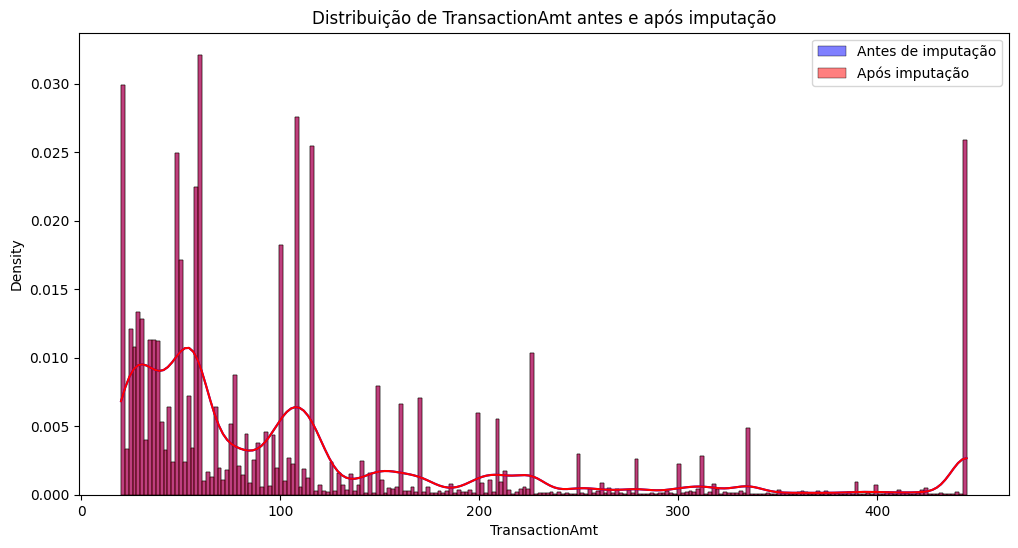

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(train_transaction['TransactionAmt'], kde=True, color='blue', label='Antes de imputação', stat="density")
sns.histplot(train_transaction['TransactionAmt'], kde=True, color='red', label='Após imputação', stat="density")
plt.title('Distribuição de TransactionAmt antes e após imputação')
plt.legend()
plt.show()


## Conclusão

Abaixo, detalho as etapas realizadas para tratar e verificar os valores ausentes nos datasets train_identity e train_transaction:

1. Verificação Inicial de Valores Ausentes

- A primeira etapa foi realizar uma verificação completa de quais colunas apresentam valores ausentes em ambos os datasets:

    No train_identity, as colunas com o maior número de valores ausentes foram identificadas, como id_24, id_25, id_07, entre outras. Muitas dessas colunas tinham uma porcentagem muito alta de dados ausentes (acima de 90%).

    No train_transaction, várias colunas, como dist2, D7, D13, D14, D12, entre outras, também apresentavam um número significativo de valores ausentes.

2. Remoção de Colunas com Muitos Valores Ausentes

- As colunas que apresentavam mais de 90% de valores ausentes foram removidas para evitar que essas variáveis não informativas impactassem negativamente o modelo. Essa remoção foi feita nas colunas:

    No train_identity, removemos as colunas como id_24, id_25, id_07, etc., que tinham uma quantidade excessiva de valores ausentes.

    Essa remoção assegura que o modelo não seja afetado por colunas que não contribuem de forma significativa para a análise.

3. Imputação de Valores Ausentes

- Após a remoção das colunas com muitos valores ausentes, os valores faltantes nas colunas restantes foram imputados:

- Para variáveis numéricas no train_identity, como id_01, id_02, etc., foi aplicada a mediana para preencher os valores ausentes. A mediana foi escolhida para evitar distorções causadas por valores extremos (outliers).

- Para variáveis categóricas (como DeviceType e outras), a moda foi utilizada para imputar os valores ausentes. A moda foi escolhida, pois ela representa o valor mais frequente, sendo uma escolha adequada para preencher dados categóricos com valor comum.

4. Verificação da Distribuição de TransactionAmt

- No dataset train_transaction, a variável TransactionAmt apresentou uma distribuição com alguns valores ausentes. Para verificar o impacto da imputação (que não foi explicitada diretamente no código anterior, mas assumindo-se que a mediana seria aplicada caso necessário), a distribuição de TransactionAmt foi comparada antes e depois da imputação. Um gráfico de densidade foi gerado para visualizar as mudanças na distribuição da variável, ajudando a identificar se a imputação teve algum impacto significativo nos dados.

# Definição da Arquitetura LSTM

Como as LSTMs são sensíveis a escala dos dados, normalizar as variáveis é importante para melhorar a convergência do modelo e garantir que ele aprenda de forma mais eficiente. A normalização transforma as variáveis para que elas fiquem em uma faixa de valores próxima de 0 (usando a média e o desvio padrão).

In [ ]:
scaler = StandardScaler()

train_transaction_scaled = scaler.fit_transform(train_transaction.select_dtypes(include=['number']))

print(train_transaction_scaled[:5])

[[-1.73204787 -0.19041718 -1.57798669 ...         nan         nan
          nan]
 [-1.73204201 -0.19041718 -1.57798648 ...         nan         nan
          nan]
 [-1.73203614 -0.19041718 -1.57797175 ...         nan         nan
          nan]
 [-1.73203028 -0.19041718 -1.57796525 ...         nan         nan
          nan]
 [-1.73202441 -0.19041718 -1.57796374 ... -0.08280306 -0.13804266
  -0.12356819]]


O modelo LSTM precisa de sequências temporais para aprender as dependências entre as transações ao longo do tempo. Para transações financeiras, pode ser interessante tratar cada transação como uma sequência única, ou, caso haja transações associadas a diferentes timestamps, fazer grupos em sequências.

Se estivermos tratando cada transação como uma sequência de um único timestep, podemos reorganizar os dados como:

In [ ]:
X_train = train_transaction_scaled.reshape((train_transaction_scaled.shape[0], 1, train_transaction_scaled.shape[1]))

print(X_train.shape)


(590540, 1, 380)


Antes de treinar o modelo, precisamos dividir os dados em conjuntos de treinamento e teste. A divisão dos dados ajuda a evitar o overfitting e garante que o modelo seja testado com dados não vistos durante o treinamento.

In [ ]:
y_train = train_transaction['isFraud'].values

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(472432, 1, 380) (118108, 1, 380) (472432,) (118108,)


# Arquitetura LSTM

A rede neural LSTM projetada para este problema de detecção de fraudes foi definida com base em três critérios principais: capacidade de aprendizado temporal, prevenção de overfitting e adequação ao problema de classificação binária.

- Camadas LSTM

  - A primeira camada LSTM possui 64 neurônios, com função de ativação tanh.

    Essa camada é responsável por processar as sequências de entrada e aprender padrões temporais iniciais nas transações.

  - Utilizar a opção return_sequences=True, permitindo que a saída completa da sequência seja passada para a próxima camada.

  - A segunda camada LSTM possui 32 neurônios, também com função de ativação tanh.

    Diferente da primeira, esta camada retornara apenas o último estado oculto (return_sequences=False), que resume a sequência em uma representação compacta.

  - Essa configuração facilita a captura de dependências de mais alto nível nas transações.

- Regularização com Dropout

  - Entre as camadas LSTM foi aplicado Dropout de 20%, que desativa aleatoriamente conexões durante o treinamento.

  - O objetivo é reduzir o risco de overfitting, que é comum em bases desbalanceadas como a de detecção de fraudes.

- Camada de Saída

  - Adicionar uma camada densa final com 1 neurônio e função de ativação sigmoid.

  - Essa configuração é adequada para problemas de classificação binária, pois gera uma probabilidade entre 0 e 1 indicando se a transação é ou não fraudulenta.

- Função de Perda e Otimizador

  - Compilar modelo usando a função de perda binary crossentropy, apropriada para tarefas de classificação binária.

  - O otimizador escolhido foi o Adam, por sua eficiência em problemas de larga escala e pela capacidade de adaptação da taxa de aprendizado durante o treinamento.

  - A métrica principal será a acurácia, complementada posteriormente com métricas como precision, recall, F1-score e AUC-ROC para uma avaliação mais completa.

# Verificação e conversão da variável-alvo (isFraud)

Garante que isFraud esteja numérica e remove linhas sem rótulo.

In [ ]:
# Garantir que isFraud é numérica e remover linhas sem rótulo
train_transaction['isFraud'] = pd.to_numeric(train_transaction['isFraud'], errors='coerce')
train_transaction = train_transaction.dropna(subset=['isFraud'])
train_transaction['isFraud'] = train_transaction['isFraud'].astype(int)


# Imputação de valores ausentes (numéricas → mediana; categóricas → moda)
Cria imputadores, separa target das features e salva uma cópia de TransactionAmt ANTES da imputação para comparação posterior.

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

# Identificar colunas numéricas e categóricas
num_cols = train_transaction.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train_transaction.select_dtypes(exclude=[np.number]).columns.tolist()

# Não incluir a target nas features numéricas
num_cols_no_target = [c for c in num_cols if c != 'isFraud']

# Guardar a distribuição de TransactionAmt ANTES (para o gráfico)
transaction_amt_before = train_transaction['TransactionAmt'].copy()

# Imputadores
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Imputar numéricas (sem a target)
train_transaction[num_cols_no_target] = num_imputer.fit_transform(train_transaction[num_cols_no_target])

# Imputar categóricas (se houver)
if len(cat_cols) > 0:
    train_transaction[cat_cols] = cat_imputer.fit_transform(train_transaction[cat_cols])

# Guardar a distribuição de TransactionAmt DEPOIS (para o gráfico)
transaction_amt_after = train_transaction['TransactionAmt'].copy()


# Distribuição de TransactionAmt antes e após imputação
Compara visualmente o impacto da imputação na variável de valor da transação.

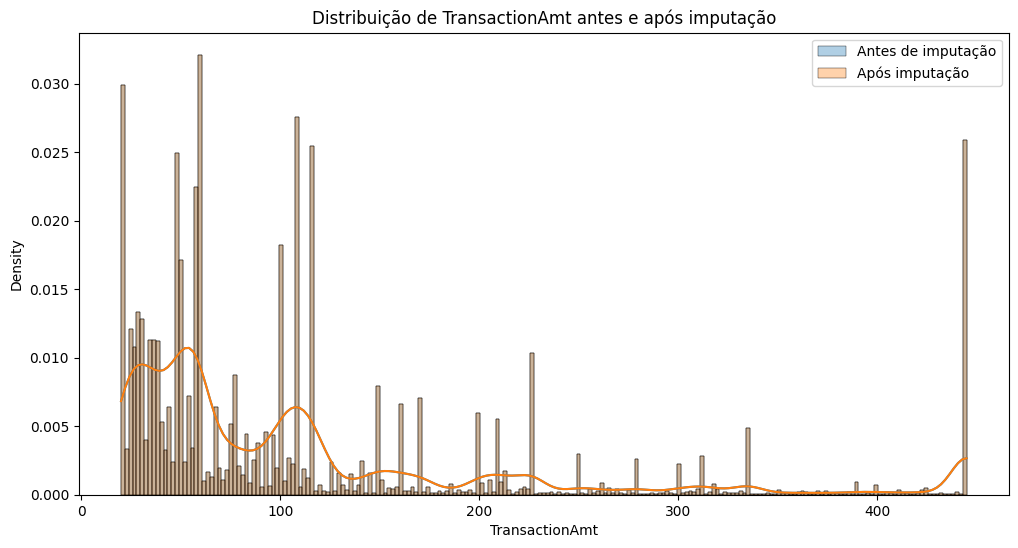

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(transaction_amt_before, kde=True, label='Antes de imputação', stat="density", alpha=0.35)
sns.histplot(transaction_amt_after,  kde=True, label='Após imputação',  stat="density", alpha=0.35)
plt.title('Distribuição de TransactionAmt antes e após imputação')
plt.legend()
plt.show()


# Seleção de features numéricas e padronização
Seleciona apenas features numéricas (sem a target), trata infinitos e padroniza com StandardScaler.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Selecionar apenas features numéricas (sem a target)
X_num = train_transaction[num_cols_no_target].copy()

# Substituir infinitos por NaN e reimputar se necessário
X_num = X_num.replace([np.inf, -np.inf], np.nan)
if X_num.isna().any().any():
    X_num[:] = SimpleImputer(strategy='median').fit_transform(X_num)

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Target
y = train_transaction['isFraud'].values



#Seleção de features numéricas e padronização
Reorganiza as amostras para o formato esperado pela LSTM: (amostras, timesteps=1, features).

In [ ]:
# Para LSTM de 1 timestep
X_seq = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_seq.shape


(590540, 1, 379)

#Divisão treino/teste
Mantém a proporção de fraudes entre treino e teste para avaliação consistente.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes ->", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes -> (472432, 1, 379) (118108, 1, 379) (472432,) (118108,)


# Arquitetura LSTM para detecção de fraude
Configura uma LSTM empilhada com dropout para reduzir overfitting e camada densa sigmoide para classificação binária.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()


/home/ubuntu/ponderada/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │       113,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,113 (492.63 KB)

 Trainable params: 126,113 (492.63 KB)

 Non-trainable params: 0 (0.00 B)

# Compilação e treinamento do modelo
Compila com binary_crossentropy e adam, e treina por poucas épocas como ponto de partida.

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,         # aumente conforme necessidade (ex.: 10–20+)
    batch_size=512,   # ajuste conforme memória disponível
    verbose=1
)


Epoch 1/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9694 - loss: 0.1250 - val_accuracy: 0.9737 - val_loss: 0.0997
Epoch 2/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9741 - loss: 0.0984 - val_accuracy: 0.9751 - val_loss: 0.0950
Epoch 3/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9756 - loss: 0.0930 - val_accuracy: 0.9756 - val_loss: 0.0910
Epoch 4/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9765 - loss: 0.0895 - val_accuracy: 0.9763 - val_loss: 0.0887
Epoch 5/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9773 - loss: 0.0863 - val_accuracy: 0.9768 - val_loss: 0.0872


#Distribuição da classe no conjunto de teste
Mostra o desbalanceamento de y_test para contextualizar as métricas.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

unique, counts = np.unique(y_test, return_counts=True)
dist_df = pd.DataFrame({"isFraud": unique, "count": counts})
dist_df["perc"] = dist_df["count"] / dist_df["count"].sum()

print(dist_df)


   isFraud   count      perc
0        0  113975  0.965007
1        1    4133  0.034993


# Curvas de aprendizado (loss e accuracy)
Avalia overfitting/subfitting ao longo das épocas.

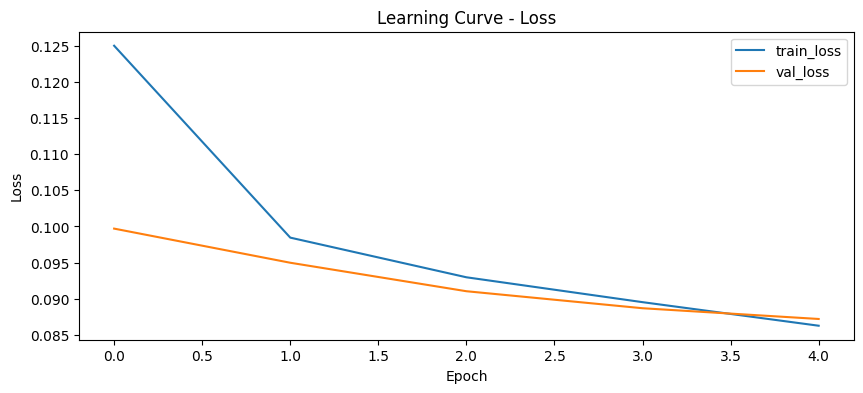

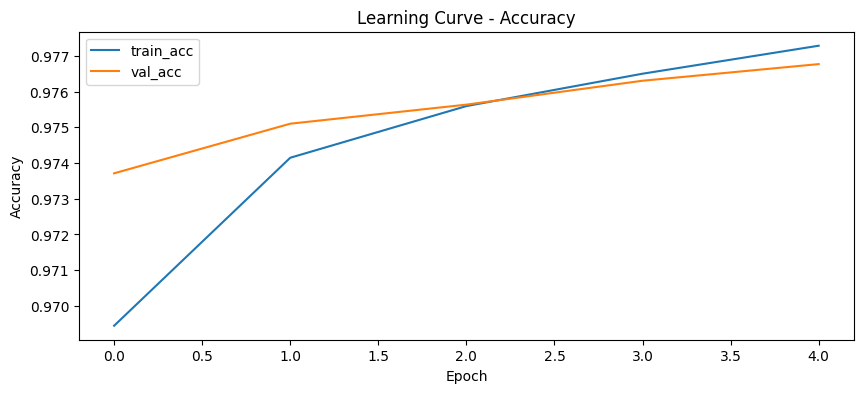

In [ ]:
# history: objeto retornado por model.fit
hist = history.history

plt.figure(figsize=(10,4))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Learning Curve - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.title("Learning Curve - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Predições de probabilidade
Gera y_proba (probabilidades) e rótulos com threshold padrão 0.5.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Probabilidades previstas
y_proba = model.predict(X_test).ravel()

# Predição binária com threshold 0.5
y_pred_05 = (y_proba >= 0.5).astype(int)

print("Exemplo de probabilidades:", y_proba[:5])


3691/3691 ━━━━━━━━━━━━━━━━━━━━ 3s 835us/step
Exemplo de probabilidades: [0.00362251 0.03818199 0.00392837 0.0025211  0.00126677]


# Matriz de confusão e relatório de classificação (threshold=0.5)
Mostra acertos/erros por classe e métricas clássicas no corte padrão.

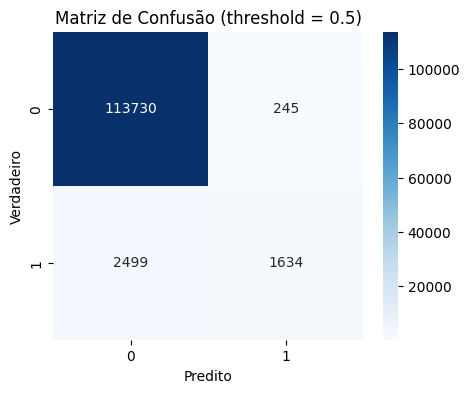

Relatório de classificação (threshold = 0.5)
              precision    recall  f1-score   support

           0     0.9785    0.9979    0.9881    113975
           1     0.8696    0.3954    0.5436      4133

    accuracy                         0.9768    118108
   macro avg     0.9241    0.6966    0.7658    118108
weighted avg     0.9747    0.9768    0.9725    118108



In [ ]:
cm = confusion_matrix(y_test, y_pred_05)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (threshold = 0.5)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

print("Relatório de classificação (threshold = 0.5)")
print(classification_report(y_test, y_pred_05, digits=4))


# Curva ROC e AUC-ROC
Avalia separabilidade global do modelo; útil mesmo com desbalanceamento.

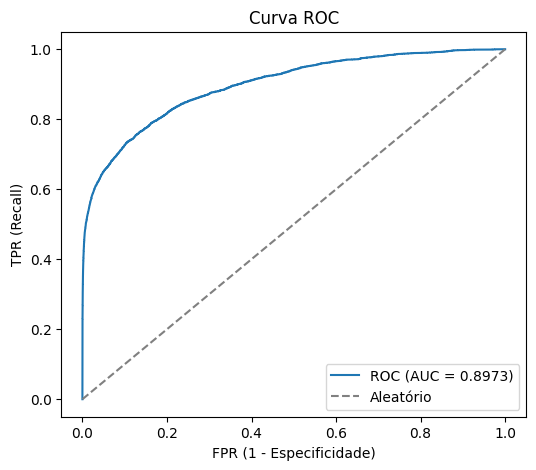

AUC-ROC: 0.897327


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Recall)")
plt.title("Curva ROC")
plt.legend()
plt.show()

print(f"AUC-ROC: {roc_auc:.6f}")


# Curva Precisão-Recall e Average Precision (PR AUC)
Mais informativa em dados desbalanceados (fraudes raras).

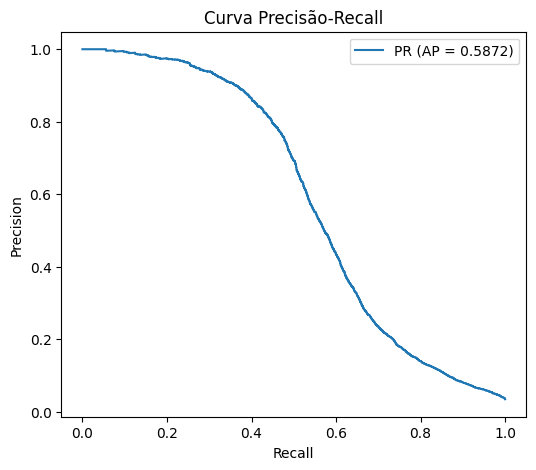

Average Precision (PR AUC): 0.587162


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precisão-Recall")
plt.legend()
plt.show()

print(f"Average Precision (PR AUC): {ap:.6f}")


# Sweep de threshold e escolha ótima (por F1 ou Youden)
Compara métricas ao variar o cutoff e sugere um threshold.

Melhor por F1:
threshold         0.250000
precision         0.754011
recall            0.477619
f1                0.584802
TP             1974.000000
FP              644.000000
FN             2159.000000
TN           113331.000000
Name: 24, dtype: float64

Melhor por Youden J:
threshold         0.040000
precision         0.188109
recall            0.742560
youden_j          0.626341
TP             3069.000000
FP            13246.000000
FN             1064.000000
TN           100729.000000
Name: 3, dtype: float64


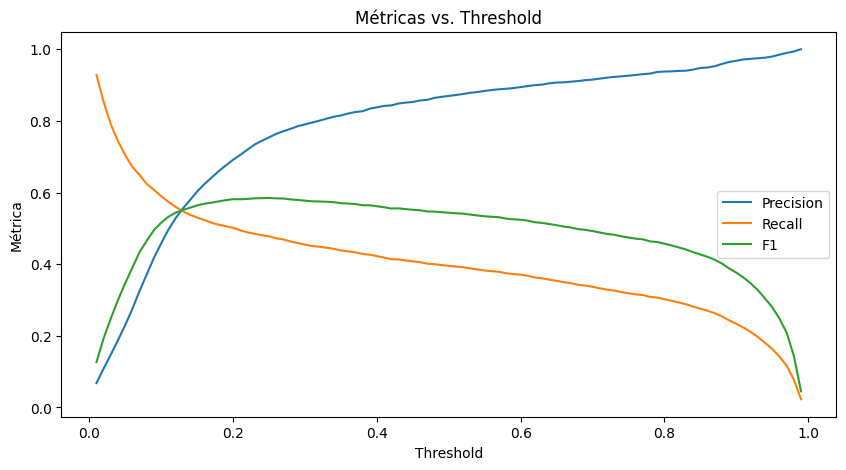

In [ ]:
from sklearn.metrics import f1_score

def youden_j(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn + 1e-12)  # sensibilidade/recall
    tnr = tn / (tn + fp + 1e-12)  # especificidade
    return tpr + tnr - 1

thr_grid = np.linspace(0.01, 0.99, 99)
rows = []
for t in thr_grid:
    y_hat = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    j = youden_j(y_test, y_proba, t)
    rows.append([t, precision, recall, f1, j, tp, fp, fn, tn])

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","f1","youden_j","TP","FP","FN","TN"])

best_f1 = thr_df.loc[thr_df["f1"].idxmax()]
best_j  = thr_df.loc[thr_df["youden_j"].idxmax()]

print("Melhor por F1:")
print(best_f1[["threshold","precision","recall","f1","TP","FP","FN","TN"]])
print("\nMelhor por Youden J:")
print(best_j[["threshold","precision","recall","youden_j","TP","FP","FN","TN"]])

plt.figure(figsize=(10,5))
plt.plot(thr_df["threshold"], thr_df["precision"], label="Precision")
plt.plot(thr_df["threshold"], thr_df["recall"],    label="Recall")
plt.plot(thr_df["threshold"], thr_df["f1"],        label="F1")
plt.xlabel("Threshold")
plt.ylabel("Métrica")
plt.title("Métricas vs. Threshold")
plt.legend()
plt.show()


# Matriz de confusão no threshold ótimo (ex.: F1)
Recalcula confusão e relatório usando o threshold sugerido.

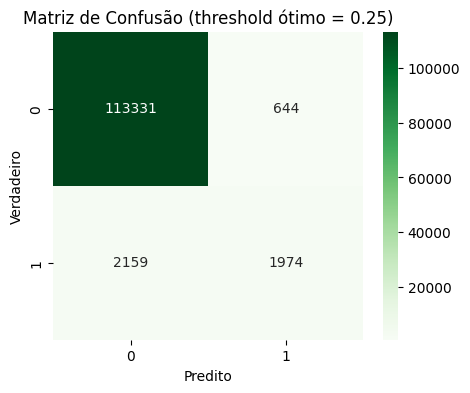

Relatório no threshold ótimo (0.25)
              precision    recall  f1-score   support

           0     0.9813    0.9943    0.9878    113975
           1     0.7540    0.4776    0.5848      4133

    accuracy                         0.9763    118108
   macro avg     0.8677    0.7360    0.7863    118108
weighted avg     0.9734    0.9763    0.9737    118108



In [ ]:
t_opt = float(best_f1["threshold"])  # ou best_j["threshold"]
y_pred_opt = (y_proba >= t_opt).astype(int)

cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Greens")
plt.title(f"Matriz de Confusão (threshold ótimo = {t_opt:.2f})")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

print(f"Relatório no threshold ótimo ({t_opt:.2f})")
print(classification_report(y_test, y_pred_opt, digits=4))


# Curva de calibração
Verifica se as probabilidades previstas são bem calibradas.

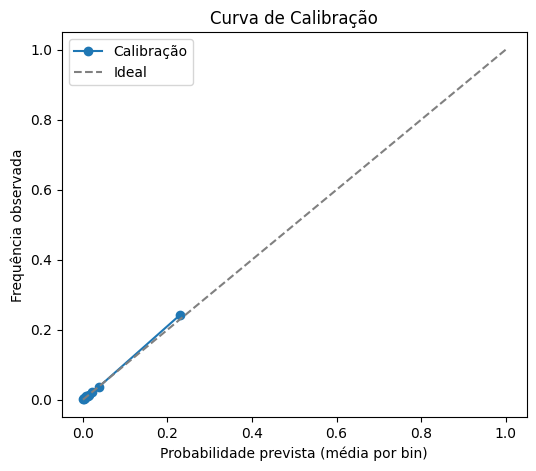

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="Calibração")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="Ideal")
plt.xlabel("Probabilidade prevista (média por bin)")
plt.ylabel("Frequência observada")
plt.title("Curva de Calibração")
plt.legend()
plt.show()


# Tabela-resumo das principais métricas
Consolida métricas-chave para facilitar sua conclusão.

In [ ]:
from sklearn.metrics import precision_score, recall_score

def metrics_at(y_true, y_score, thr):
    y_hat = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    return {
        "threshold": thr,
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    }

summary = pd.DataFrame([
    metrics_at(y_test, y_proba, 0.50),
    metrics_at(y_test, y_proba, float(best_f1["threshold"])),
    metrics_at(y_test, y_proba, float(best_j["threshold"])),
])

summary.index = ["thr=0.50", "thr=best_F1", "thr=best_YoudenJ"]
summary


,threshold,precision,recall,f1,TP,FP,FN,TN
thr=0.50,0.50,0.869611,0.395354,0.543580,1634,245,2499,113730
thr=best_F1,0.25,0.754011,0.477619,0.584802,1974,644,2159,113331
thr=best_YoudenJ,0.04,0.188109,0.742560,0.300176,3069,13246,1064,100729


A base de teste é bem desbalanceada, com 113.975 amostras de não fraude e 4.133 de fraude, ou seja, cerca de 96,50% contra 3,50%. Isso faz a acurácia parecer alta por padrão, então olhamos para precisão, recall, F1, curvas ROC e PR e varremos o limiar de decisão.

Com o threshold padrão de 0,50, o modelo ficou conservador. Obtivemos 1.634 verdadeiros positivos, 245 falsos positivos, 2.499 falsos negativos e 113.730 verdadeiros negativos. Na classe de fraude a precisão foi 0,8696, o recall 0,3954 e o F1 0,5436. A leitura aqui é direta: quando o modelo acusa fraude, ele acerta bastante, mas deixa passar muitas fraudes. Esse corte faria sentido se o custo de investigar um alerta falso for alto e perder parte das fraudes for aceitável.

Quando buscamos o melhor F1 a varredura indicou threshold 0,25. Nessa configuração tivemos 1.974 verdadeiros positivos, 644 falsos positivos, 2.159 falsos negativos e 113.331 verdadeiros negativos. Na classe de fraude a precisão ficou em 0,7540, o recall em 0,4776 e o F1 em 0,5848, com acurácia global de 0,9763. Aqui recuperamos mais fraudes em comparação com 0,50, pagando um pouco mais de falsos positivos. Esse equilíbrio parece um bom ponto de partida operacional enquanto não temos uma função de custo explícita.

Também testamos o threshold ótimo por Youden J em 0,04 para entender um cenário agressivo de captura. O recall subiu para 0,7426 com 3.069 verdadeiros positivos e 1.064 fraudes perdidas, mas a precisão caiu para 0,1881 e os falsos positivos saltaram para 13.246. Isso só faz sentido se a triagem seguinte for barata e a prioridade máxima for não deixar fraude passar.

Sobre o modelo em si, usamos uma arquitetura LSTM com 64 unidades retornando sequências, dropout de 0,2, seguida de uma LSTM de 32 unidades, mais dropout e uma saída sigmoide. Compilamos com binary crossentropy e Adam. As curvas de aprendizado mostraram perda de treino e validação caindo de forma estável ao longo de 5 épocas e as acurácias se mantendo próximas, sem sinais fortes de overfitting nesse horizonte curto. Como alimentamos a LSTM com um timestep por amostra, ela se comporta na prática como uma rede recorrente aplicada a vetores estáticos. Eu e o Henrique buscamos explorar primeiro esse setup simples para estabelecer uma linha de base e medir o ganho real de um classificador neural sob o pré-processamento que fizemos. Nossa hipótese é que o benefício específico de LSTM aparece de verdade quando há janelas temporais por usuário ou dispositivo, com dependências entre transações, e não apenas um snapshot.

Do ponto de vista de decisão, sem custos definidos recomendamos operar inicialmente com threshold 0,25 porque ele entrega um F1 melhor na classe positiva e um trade-off mais equilibrado entre cobertura de fraude e esforço de revisão. Se o custo de falso positivo for alto podemos voltar para 0,50. Se a prioridade for recall máximo com uma fila barata de revisão automatizada adotamos algo próximo de 0,04 sabendo que a precisão despenca.

Nossas hipóteses para próximos passos são claras. Primeiro estimar custos de falso positivo e falso negativo e otimizar o limiar por custo esperado em vez de apenas F1. Segundo testar calibração das probabilidades e aplicar Platt ou Isotonic se a curva de calibração estiver afastada da diagonal.